# Exploratory data analysis on message history

# Preliminary notes

The area of study is one text message coming from or going to my phone, and it requires intent either of me or of one my contacts to send a text message (be it an iMessage or a SMS text)

# Setup

In [1]:
# Setup used to include some activation of a venv and installation of packages via !pip, though these were removed in favor of a venv in which the imports below are properly installed. 
# TODO create a requirements.txt so that this notebook is more portable

## Installs

## Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta

## Options

In [3]:
pd.options.display.max_rows=300

# Open file and look at general characteristics

In [4]:
sms_orig = pd.read_csv('../../../data/allmessages.csv',  date_format='ISO8601')

/var/folders/2q/8lbypypn4xb0wb2w4nmv421c0000gn/T/ipykernel_9387/1311148020.py:1: DtypeWarning: Columns (4,7,11) have mixed types. Specify dtype option on import or set low_memory=False.
  sms_orig = pd.read_csv('../../../data/allmessages.csv',  date_format='ISO8601')


In [5]:
sms_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177515 entries, 0 to 177514
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Chat Session     177515 non-null  object
 1   Message Date     177515 non-null  object
 2   Delivered Date   65457 non-null   object
 3   Read Date        101140 non-null  object
 4   Edited Date      50 non-null      object
 5   Service          177515 non-null  object
 6   Type             177515 non-null  object
 7   Sender ID        97926 non-null   object
 8   Sender Name      87976 non-null   object
 9   Status           177246 non-null  object
 10  Replying to      480 non-null     object
 11  Subject          19 non-null      object
 12  Text             166195 non-null  object
 13  Attachment       11315 non-null   object
 14  Attachment type  11318 non-null   object
dtypes: object(15)
memory usage: 20.3+ MB


## What to do with Attachments

In [6]:
sms_orig['Attachment type'].value_counts()

Attachment type
Image         10476
Video           400
Attachment      311
Audio           131
Name: count, dtype: int64

In [7]:
sms_orig[sms_orig['Attachment type']=='Video'].head()

,Chat Session,Message Date,Delivered Date,Read Date,Edited Date,Service,Type,Sender ID,Sender Name,Status,Replying to,Subject,Text,Attachment,Attachment type
236,Sara Stilleke,2020-11-12 18:44:45,2020-11-12 18:44:47,NaN,NaN,iMessage,Outgoing,NaN,NaN,Delivered,NaN,NaN,NaN,IMG_3761.MOV,Video
391,Sara Stilleke,2020-11-18 14:06:56,2020-11-18 14:07:02,NaN,NaN,iMessage,Outgoing,NaN,NaN,Delivered,NaN,NaN,NaN,IMG_3841.MOV,Video
411,Sara Stilleke,2020-11-18 22:12:21,2020-11-18 22:12:24,NaN,NaN,iMessage,Outgoing,NaN,NaN,Delivered,NaN,NaN,NaN,IMG_3862.MOV,Video
1701,Sara Stilleke,2020-12-17 16:16:30,2020-12-17 16:16:33,NaN,NaN,iMessage,Outgoing,NaN,NaN,Delivered,NaN,NaN,NaN,IMG_4103.MOV,Video
1717,Sara Stilleke,2020-12-18 15:53:36,2020-12-18 15:53:40,NaN,NaN,iMessage,Outgoing,NaN,NaN,Delivered,NaN,NaN,NaN,IMG_4136.MOV,Video


When we start thinking of creating chat 'sitdowns' where both participants are actively texting, and want to decide a cutoff for that, we will want to include these, however when describing the text attributes of messages, these in the text could be a problem. Further EDA with a dataset containing these will need to be done to determine whether videos are often on the tail end of sessions.

# Subset columns

Here we take only the columns that we need for a textual analysis of texts, so we only need a subset of columns. 
- Chat session because we need to know who the text conversation is with
- Message date for time-series analysis and to see the evolution
- Service to see whether it is an iMessage or a SMS, and thus verify a hypothesis about response times on SMS vs iMessages
- Type to understand whether I sent 'Outgoing' or I received 'Incoming'
- Text to have the raw characters that consistute the communication

In [8]:
sms_orig = sms_orig[['Chat Session', 'Message Date', 'Service', 'Type',  'Text']]

# EDA to filter out least contacted senders

Create config class to store specific configuration options

In [9]:
class Config:
    MESSAGE_COUNT_CUTOFF  = 300
    SESSION_TIMEOUT = 15 # in minutes

## Inspect the frequency of senders in the SMS data

In [10]:
message_count = sms_orig['Chat Session'].value_counts()

<Axes: >

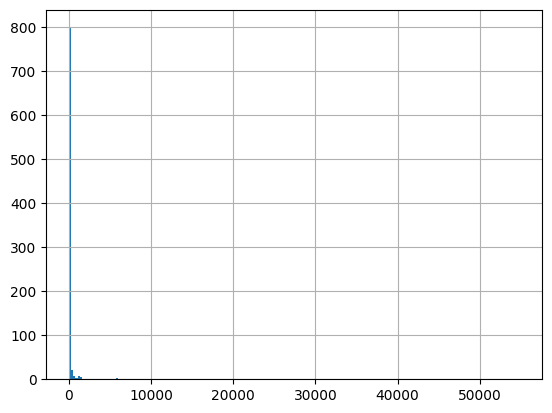

In [11]:
message_count.hist(bins=200)

The distributions of messages per sender is very long-tailed. To give a more useful view, we switch the x axis to log scale.

Text(0, 0.5, 'Frequency')

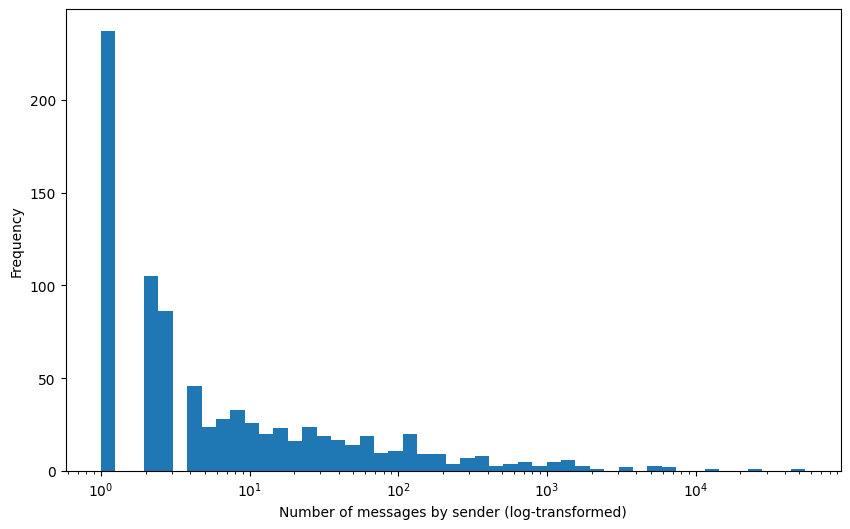

In [12]:
logbins = np.geomspace(message_count.min(), message_count.max(), 50)

plt.figure(figsize=(10, 6))
plt.hist(message_count, bins=logbins)
plt.xscale('log')
plt.xlabel('Number of messages by sender (log-transformed)')
plt.ylabel('Frequency')

In [13]:
'In  an attempt to make the EDA less sensitive to senders I barely interacted with, let\'s cut all senders having sent less than {} messages.'.format(Config.MESSAGE_COUNT_CUTOFF)

"In  an attempt to make the EDA less sensitive to senders I barely interacted with, let's cut all senders having sent less than 300 messages."

In [14]:
all_senders  = message_count.index
selected_senders = message_count[message_count >= Config.MESSAGE_COUNT_CUTOFF].index
sms = sms_orig[sms_orig['Chat Session'].isin(selected_senders)]


In [15]:
'Setting the cutoff at {0} messages yields {1:.1%} percent of messages and {2:.1%} percent of senders'.format(int(Config.MESSAGE_COUNT_CUTOFF), float(sms.shape[0] / sms_orig.shape[0]), float(selected_senders.size / all_senders.size))

'Setting the cutoff at 300 messages yields 90.9% percent of messages and 5.8% percent of senders'

## Inspect the message type

In [16]:
sms['Type'].value_counts()

Type
Incoming        88424
Outgoing        72851
Notification       27
Name: count, dtype: int64

In [17]:
sms[sms['Type']=='Notification'].head(1)

,Chat Session,Message Date,Service,Type,Text
56371,Addison Edwards,2018-04-12 22:43:37,iMessage,Notification,Addison Edwards kept an audio message from you.


Notifications are not in the area of study, thus they will be discarded for the rest of the EDA

In [18]:
sms = sms[sms['Type'] != 'Notification']

## Inspect time series by month of SMS activity

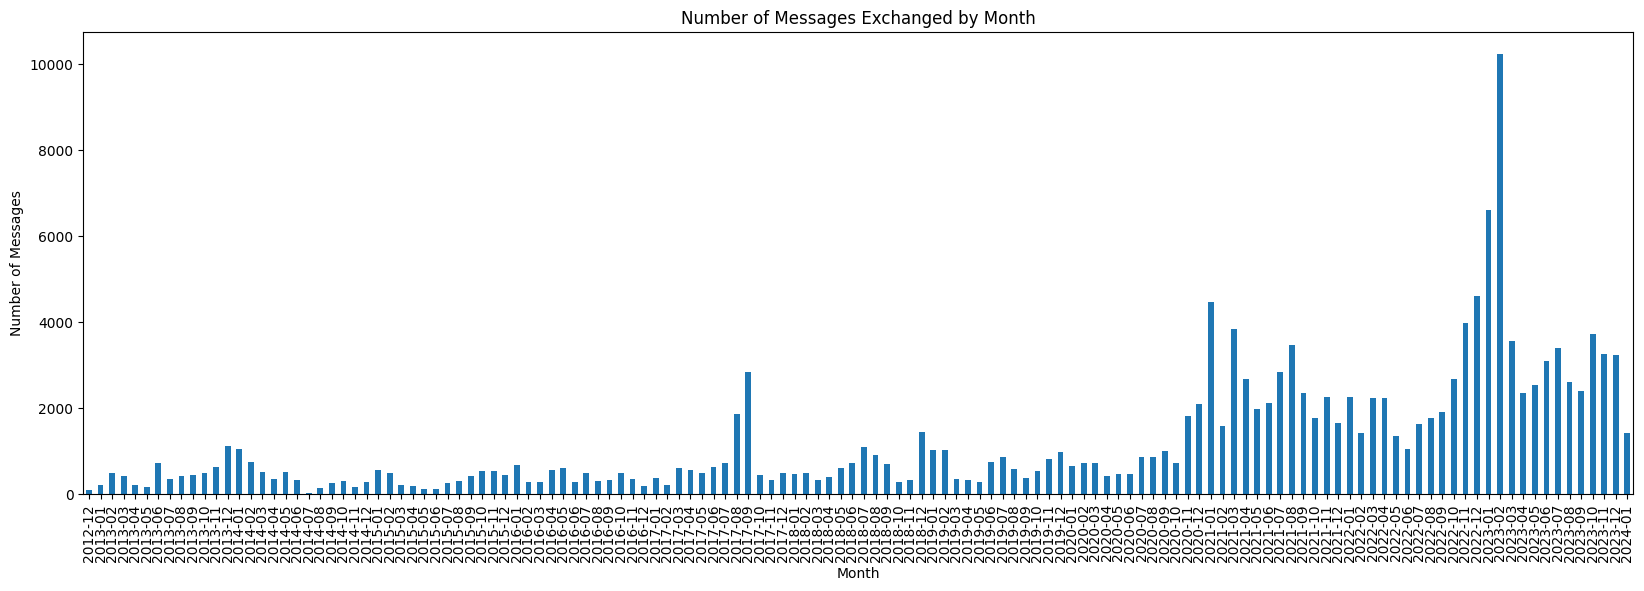

In [19]:
sms['date'] = pd.to_datetime(sms['Message Date'])

# Extract the month from the 'date' column
sms['month'] = sms['date'].dt.to_period('M')

# Group the data by month and count the number of messages for each month
messages_by_month = sms.groupby('month').size()

# Plot the number of messages exchanged by month
plt.figure(figsize=(20, 6))
messages_by_month.plot(kind='bar', xlabel='Month', ylabel='Number of Messages', title='Number of Messages Exchanged by Month')

plt.show()

## Create a few dimensions, measures

In [20]:
sms['Text Length'] = sms['Text'].str.len()
sms['Message Day'] = pd.to_datetime(sms['Message Date']).dt.round('D')
sms['Message Hour'] = pd.to_datetime(sms['Message Date']).dt.to_period('h')
sms['Message Month'] = pd.to_datetime(sms['Message Date']).dt.to_period('M')
sms['Message Yearmo'] =  pd.to_datetime(sms['Message Date']).apply(lambda x: x.strftime('%Y%m'))


sms['Message Has Heart Kiss'] = sms['Text'].map(lambda x : '😘' in str(x))
sms['Message Has Happy Kiss'] = sms['Text'].map(lambda x : '😚' in str(x))

# What month do I tend to text most in?

In [21]:
pd.to_datetime(sms['Message Date']).dt.month_name().value_counts()

Message Date
January      19703
February     17642
December     16552
November     14365
August       13193
March        13006
September    12976
July         12486
October      11870
June         10205
April        10194
May           9083
Name: count, dtype: int64

# Create a visual EDA function that allows one to easily plot:
- x-axis: mostly yearmonth, probalbly also different time cuts are the dimension
- y axis: stacked bar charts (possibly sum to 100%) for various measures (% service, % people session, message type, incoming/outgoing)
- 

In [22]:
[x in ['Chat Session', 'Message Date', 'Service', 'Type', 'Text', 'date',
       'month', 'Text Length', 'Message Day', 'Message Hour', 'Message Month',
       'Message Yearmo', 'Message Has Heart Kiss', 'Message Has Happy Kiss'] for  x in ['Type']]

[True]

In [23]:
def groupByTime(data=sms, by_col='Type', agg='sum', extracttopnvalues=300, stack=True, **kwargs):
    """
    This function groups its first argument, a dataframe (must contain a column called 'Text Length'), 
    by an array of column names by_col 
    (optionally extracgint the top integer extracttopnvalues values and grouping the rest into other≠≠ ),
      aggregates the text length by either sum or count
    
    It then returns the stacked to 100% barchart 
    """
    date_division_column = 'Message Yearmo'
    text_length_column = 'Text Length'

    assert(text_length_column in sms.columns)
    assert(date_division_column in sms.columns)
    assert(by_col in sms.columns)

    sms.loc[sms[by_col].isin((sms[by_col].value_counts()[sms[by_col].value_counts() < extracttopnvalues]).index), [by_col]] = 'other'

    if agg == 'sum':
        messages_by_month = sms.groupby([date_division_column, by_col])[text_length_column].sum()
        ylabel_agg = 'Aggregate Message Length'
    elif agg =='count':
        messages_by_month = sms.groupby([date_division_column, by_col])[text_length_column].count()
        ylabel_agg = 'Number of Messages'
    else:
        KeyError("Err: agg is not within expected parameters.")


    res = messages_by_month.unstack().fillna(0)

    if stack:
        res = res.divide(res.sum(axis=1), axis=0)
    return(res)

In [24]:
sms.columns

Index(['Chat Session', 'Message Date', 'Service', 'Type', 'Text', 'date',
       'month', 'Text Length', 'Message Day', 'Message Hour', 'Message Month',
       'Message Yearmo', 'Message Has Heart Kiss', 'Message Has Happy Kiss'],
      dtype='object')

<Axes: xlabel='Message Yearmo'>

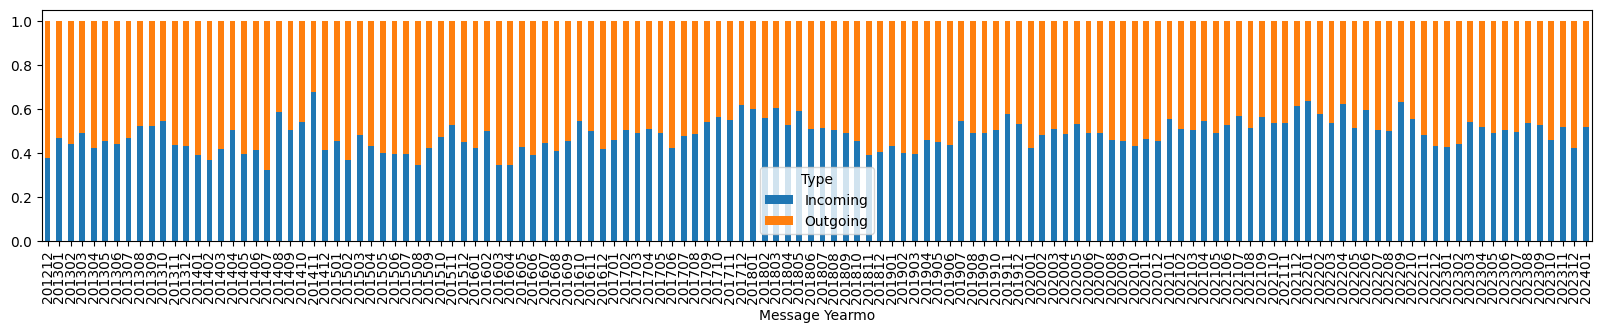

In [25]:
plt.rcParams["figure.figsize"] = (20,3)

groupByTime().plot(kind='bar', stacked=True)

In [26]:
groupByTime(data=sms, by_col='Service', agg='count').plot(kind='bar', stacked=True)

<Axes: xlabel='Message Yearmo'>

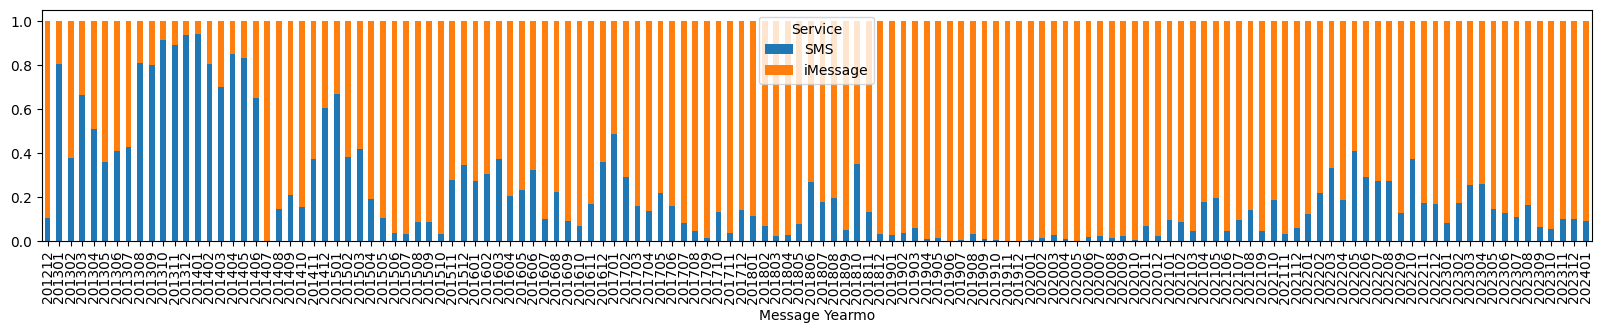

In [ ]:
groupByTime(data=sms, by_col='Service', agg='sum').plot(kind='bar', stacked=True)

TODO correlation between count and length, for service type. Am I more likely to send shorter messages via SMS compared to iMessage?

/var/folders/2q/8lbypypn4xb0wb2w4nmv421c0000gn/T/ipykernel_9314/1951362010.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'other' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  sms.loc[sms[by_col].isin((sms[by_col].value_counts()[sms[by_col].value_counts() < extracttopnvalues]).index), [by_col]] = 'other'


<Axes: xlabel='Message Yearmo'>

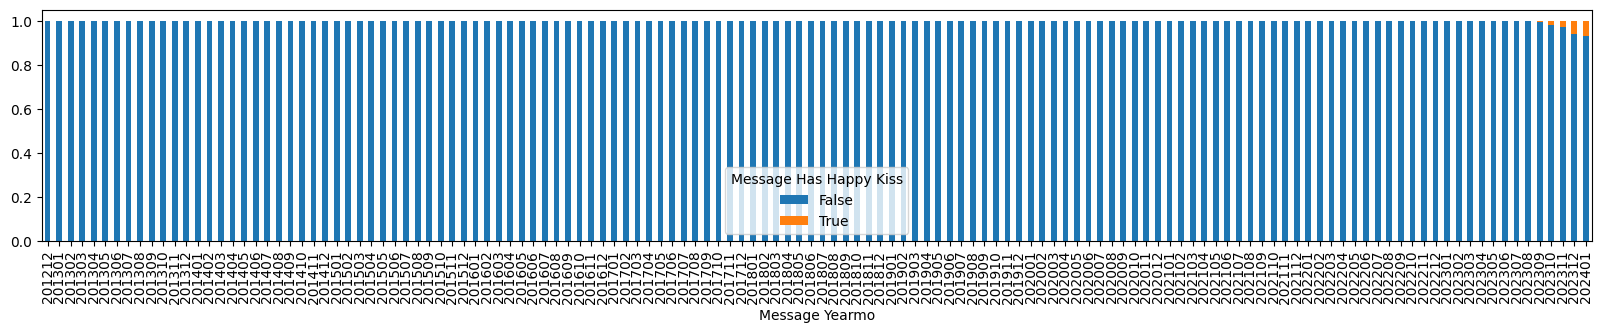

In [ ]:
groupByTime(data=sms[sms['Chat Session']=='Sara Stilleke'], by_col='Message Has Happy Kiss', agg='count').plot(kind='bar', stacked=True)

<Axes: xlabel='Message Yearmo'>

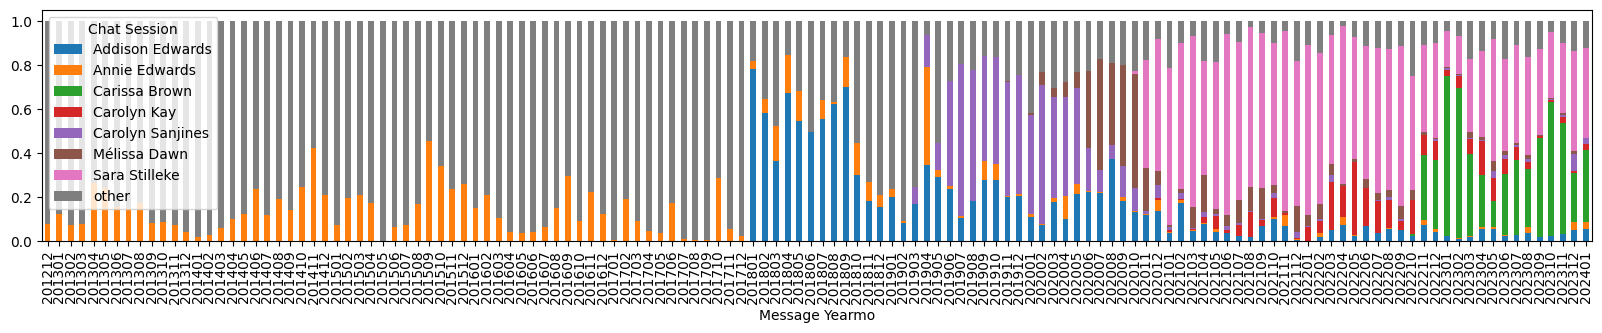

In [ ]:
groupByTime(data=sms, by_col='Chat Session', agg='count', extracttopnvalues=5000).plot(kind='bar', stacked=True)

# Feature enginnering at the message level

In [ ]:
sms.groupby(['Chat Session'])['Message Has Heart Kiss'].sum().sort_values(ascending=False).head(10)

Chat Session
Sara Stilleke       1475
other                 64
Carolyn Sanjines      45
Mélissa Dawn          13
Carolyn Kay            2
Carissa Brown          1
Addison Edwards        0
Annie Edwards          0
Name: Message Has Heart Kiss, dtype: int64

In [ ]:
sms['Text'].map(lambda x : '😘' in str(x)).value_counts()

Text
False    159675
True       1600
Name: count, dtype: int64

Tenderloin Water Athletic Team's various groupchats are aggregated into one session

In [ ]:
sms.loc[sms['Chat Session']=='Chris Swim & Darryl Pierce & Jarrod Amsterdam & James Perry & +19405773150 & Chris Farris & +14155677107 & John Vochatzer & David Young', 'Chat Session']='TWATs'
sms['Chat Session'].value_counts().head(25)

Chat Session
Sara Stilleke       54819
other               46086
Carissa Brown       24809
Addison Edwards     11977
Carolyn Kay          6504
Mélissa Dawn         5981
Carolyn Sanjines     5873
Annie Edwards        5226
Name: count, dtype: int64

In [ ]:
sms['Service'].value_counts(dropna=False)

TODO plot this over time, also answer the question am I less likely to answer an SMS than an iMessage

In [ ]:
sms[sms['Chat Session']=='Sara Stilleke']['Type'].value_counts()

TODO look at the breakdown of incoming/outgoing by Chat Session

In [ ]:
sms.info()

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)


last_year_contacts = sms[sms['date'].dt.year >= 2023]['Chat Session'].unique()

sms[sms['Chat Session'].isin(last_year_contacts)].groupby(['Chat Session'])['Type']\
.value_counts(normalize=True).unstack('Type').sort_values(by='Incoming').plot.bar(stacked=True)

In [ ]:
sms.groupby([    'Chat Session', sms['Message Day'].dt.year ])['Text Length'].sum().sort_values().tail(20)

In [ ]:
smsday = sms.groupby([
    sms['Message Day'].dt.date,
    'Chat Session']
).agg(
     {'Text Length' : ['count', 'sum']}
     
).reset_index()

In [ ]:
pd.options.display.max_rows = 100

sms.groupby(['Chat Session'])['Text Length'].count().reset_index().sort_values('Text Length').tail(100)


In [ ]:
sms.groupby(['Chat Session'])['Text Length'].mean().reset_index().sort_values('Text Length').head(10)


TODO break this down by sent/received and add count

In [ ]:
sms[sms['Chat Session']=='Kevin Oswald'][['Chat Session', 'Text']].reset_index()

In [ ]:
sms.groupby(['Chat Session'])['Text Length'].count().reset_index().sort_values('Text Length').tail(10)


In [ ]:
sms[sms['Message Day'].dt.year > 2020].groupby(['Chat Session'])['Text Length'].count().reset_index().sort_values('Text Length').tail(10)


# Remove all text sent by anyone not in the rough top 30

In [ ]:
sms['Chat Session'].value_counts().head(70)

# Look at only people I texted in the past year

In [ ]:
sms.head()

In [ ]:
last_year_contacts = sms[sms['date'].dt.year == 2024]['Chat Session'].unique()

In [ ]:
last_year_contacts

In [ ]:
messages_by_month = sms[sms['Chat Session'].isin(last_year_contacts)].groupby('month').size()

# Plot the number of messages exchanged by month
plt.figure(figsize=(20, 6))
messages_by_month.plot(kind='bar', xlabel='Month', ylabel='Number of Messages', title='Number of Messages Exchanged by Month')

plt.show()

# Session creation

ORder SMS by datetime sent, group by sender, lag the datetime, create indicator of datetime greater than 15 minutes

In [ ]:
pd.to_datetime(sms['Message Date'])

# Carissa EDA love live

In [ ]:
sms['Message Has love'] = sms['Text'].map(lambda x : 'love' in str(x).lower())
sms['Message Has live'] = sms['Text'].map(lambda x : 'live' in str(x).lower())

In [ ]:
car = sms[sms['Chat Session']=='Carissa Brown']

In [ ]:
cari = car[car['Type']=='Incoming']

In [ ]:
cari.shape

In [ ]:
cari['Message Has love'].value_counts(normalize=True)

In [ ]:
cari['Message Has live'].value_counts(normalize=True)

# Search for pens to get David for his birthday

In [ ]:
pd.options.display.max_colwidth = 160


In [ ]:
dave_texts_june = sms[np.logical_and(sms['Chat Session']=='David Young', pd.DatetimeIndex(sms['Message Date']).month==7)]['Text'].reset_index()\
    
dave_texts_june

In [ ]:
pd.DatetimeIndex(sms['Message Date']).month